In [1]:
import geopandas as gpd
from shapely.geometry import Point
import geoplot
import geoplot.crs as gcrs
import os
import pandas as pd
import re
import numpy as np
from tqdm.notebook import tqdm_notebook
from shapely.ops import unary_union
tqdm_notebook.pandas()

import pandas_bokeh
pandas_bokeh.output_notebook()

os.chdir('CO2JRC_OpenFormats/CO2Stop_Polygons Data/')

Loading BokehJS ...

In [2]:
# EU country shape mask
offshore=gpd.read_file('../eu_shapes/offshore_shapes.geojson')
onshore = gpd.read_file('../eu_shapes/country_shapes.geojson')
eu = gpd.GeoDataFrame(pd.concat([onshore,offshore]),crs = 'EPSG:4326')
eu['geometry']= eu.buffer(0)

# storage unit

In [21]:
storage_unit = pd.read_csv('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Storage_Units.csv')

# why mean capacity ten times larger
storage_unit.sort_values('EST_STORECAP_MEAN',ascending = False)[['STORAGE_UNIT_ID',
 'EST_STORECAP_MIN', 
 'EST_STORECAP_MEAN',
 'EST_STORECAP_MAX',
 'CAP_EST_METHOD',
 'STORE_CAP_MIN',
 'STORE_CAP_MEAN',
 'STORE_CAP_MAX',
 'CAP_CAL_METHOD',
 'TOTAL_STORE_CAP',
 'STORE_CAP_HCDAUGHTER',
 'EST_CAP_ENT_PRESS']].iloc[:20]


# EST_STORECAP_MEAN have many extremely large value
# STORE_CAP_HCDAUGHTER sum is around 4 Gt, doesn't make too much difference but can fill some missing value

# EST_STORECAP_ as main body, use STORE_CAP_ to fill missing value, lastly add capacity in STORE_CAP_HCDAUGHTER 
# conservative estimate: use MIN
# neural estimate: use MEAN
# optimistic estimate: use MAX

,STORAGE_UNIT_ID,EST_STORECAP_MIN,EST_STORECAP_MEAN,EST_STORECAP_MAX,CAP_EST_METHOD,STORE_CAP_MIN,STORE_CAP_MEAN,STORE_CAP_MAX,CAP_CAL_METHOD,TOTAL_STORE_CAP,STORE_CAP_HCDAUGHTER,EST_CAP_ENT_PRESS
144,DK_S_20120905093827024,3200.0,154400.0,1388000.0,Pore vol and compressibility,176.290786,6210.400302,4.565329e+04,Method 1,6210.400302,0.0,0.0
147,DK_S_20121005113449910,6800.0,154000.0,1387000.0,Pore vol and compressibility,0.000000,36636.565248,1.749392e+05,Method 1,36636.565248,0.0,0.0
145,DK_S_20120905113124838,2300.0,120000.0,368000.0,Pore vol and compressibility,86.664000,9072.138240,5.474028e+04,Method 1,9072.138240,0.0,0.0
216,PL_S_20120808115157953,0.0,93202.3,546419.7,Pore vol and storage eff coefficient,2676.467034,93202.289280,6.993640e+05,Method 1,93202.289280,0.0,0.0
215,PL_S_20120808112810552,864.6,40568.6,931783.9,Pore vol and storage eff coefficient,1071.318150,40568.563800,8.196310e+05,Method 1,40568.563800,0.0,0.0
214,PL_S_20120808112804608,864.6,39663.3,1157270.2,Pore vol and storage eff coefficient,1047.413430,39663.342360,1.009098e+06,Method 1,39663.342360,0.0,0.0
146,DK_S_20120905113606539,35.0,36000.0,114000.0,Pore vol and compressibility,0.001755,3.358748,1.001656e+01,Method 1,3.358748,0.0,0.0
213,PL_S_20120808091634004,5465.7,25213.4,547055.1,Pore vol and storage eff coefficient,5904.597960,25213.357056,4.297828e+05,Method 1,25213.357056,0.0,0.0
204,NO_S_20121106101249611,0.0,15770.0,0.0,Pore vol and storage eff coefficient,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.0,0.0
205,NO_S_20121106103720125,0.0,13600.0,0.0,Pore vol and storage eff coefficient,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.0,0.0


In [22]:
# Create our estimation value

# EST_STORECAP_ as main body, use STORE_CAP_ to fill missing value, lastly add capacity in STORE_CAP_HCDAUGHTER 

# conservative estimate: use MIN
storage_unit['conservative estimate Mt'] = storage_unit['EST_STORECAP_MIN'].replace(0,np.nan)
storage_unit['conservative estimate Mt'].fillna(storage_unit['STORE_CAP_MIN'],inplace = True)
storage_unit['conservative estimate Mt'] = storage_unit['conservative estimate Mt'] + storage_unit['STORE_CAP_HCDAUGHTER'] 

# neutral estimate: use MEAN
storage_unit['neutral estimate Mt'] = storage_unit['EST_STORECAP_MEAN'].replace(0,np.nan)
storage_unit['neutral estimate Mt'].fillna(storage_unit['STORE_CAP_MEAN'],inplace = True)
storage_unit['neutral estimate Mt'] = storage_unit['neutral estimate Mt'] + storage_unit['STORE_CAP_HCDAUGHTER']

# optimistic estimate: use MAX
storage_unit['optimistic estimate Mt'] = storage_unit['EST_STORECAP_MAX'].replace(0,np.nan)
storage_unit['optimistic estimate Mt'].fillna(storage_unit['STORE_CAP_MAX'],inplace = True)
storage_unit['optimistic estimate Mt'] = storage_unit['optimistic estimate Mt'] + storage_unit['STORE_CAP_HCDAUGHTER']

In [23]:
storage_unit[['conservative estimate Mt','neutral estimate Mt','optimistic estimate Mt']].sum()/1e3 #convert to Gt
#The GeoCapacity project 126 Gt as a conservative estimate.

conservative estimate Mt     105.449593
neutral estimate Mt         1015.604661
optimistic estimate Mt      7139.290093
dtype: float64

In [24]:
storage_unit[['conservative estimate Mt','neutral estimate Mt','optimistic estimate Mt']].describe()
# neural estimate have most non zero capacities

,conservative estimate Mt,neutral estimate Mt,optimistic estimate Mt
count,436.000000,436.000000,4.360000e+02
mean,241.856866,2329.368489,1.637452e+04
std,809.577222,13328.497962,1.242180e+05
min,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00
50%,0.217521,11.600000,0.000000e+00
75%,67.390625,233.430000,1.266027e+02
max,7014.600000,154400.000000,1.388000e+06


In [25]:
capacity_list = ['conservative estimate Mt','neutral estimate Mt','optimistic estimate Mt']
storage_unit_lite = storage_unit[['STORAGE_UNIT_ID']+capacity_list]

In [26]:


storage_unit_map = gpd.read_file('jsonversion/StorageUnits_March13.geojson')
storage_unit_map_lite = storage_unit_map[['COUNTRY','COUNTRYCOD','ID','geometry']]
storage_unit_map_lite = storage_unit_map_lite.groupby(['COUNTRY','COUNTRYCOD','ID']).agg(unary_union).reset_index()
storage_unit_map_lite = gpd.GeoDataFrame(storage_unit_map_lite, crs = 'EPSG:4326')

In [27]:


storage_unit_map_lite = storage_unit_map_lite.merge(storage_unit_lite, left_on = 'ID', right_on = 'STORAGE_UNIT_ID', how = 'left')
storage_unit_map_lite.drop('STORAGE_UNIT_ID',axis=1,inplace = True)

In [28]:
# further fillna
storage_unit_map_lite['neutral estimate Mt'].replace(0,np.nan,inplace= True)
storage_unit_map_lite['optimistic estimate Mt'].replace(0,np.nan,inplace= True)

storage_unit_map_lite['neutral estimate Mt'].fillna(storage_unit_map_lite['conservative estimate Mt'],inplace = True)
storage_unit_map_lite['optimistic estimate Mt'].fillna(storage_unit_map_lite['neutral estimate Mt'],inplace = True)
storage_unit_map_lite.fillna(0,inplace = True)


storage_unit_map_lite.to_file('storage_unit_map_lite.geojson',driver='GeoJSON')

In [29]:
storage_unit_map_lite[capacity_list].sum()/1e3
1102 GW

conservative estimate Mt     105.449593
neutral estimate Mt         1021.304661
optimistic estimate Mt      7250.500046
dtype: float64

In [30]:
# without extreme norway
storage_unit_map_lite[storage_unit_map_lite.COUNTRYCOD != 'NO'][capacity_list].sum()/1e3

conservative estimate Mt     105.449593
neutral estimate Mt          976.274661
optimistic estimate Mt      7205.470046
dtype: float64

In [31]:
storage_unit_map_lite = storage_unit_map_lite.sort_values('neutral estimate Mt',ascending= False)
storage_unit_map_lite.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=5000,
    dropdown=capacity_list,
    colormap="Viridis",
    hovertool_columns=capacity_list+['ID'],
    colormap_range = (0,100)
    )

Column(id='1345', ...)

# test if we could use regression to further fill missing value

In [32]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from bokeh.plotting import figure
from bokeh.io import show
def train_lasso(x,y):
    
    #train normal
    rg_model_normal=Lasso(alpha=0.01)
    rg_model_normal.fit(x,y)
    train_predict=rg_model_normal.predict(x)
    
    #calculate error
    MAE_normal=str(round(mean_absolute_error(x,train_predict),3))
    MAE_normal='MAE_normal '+MAE_normal
    
    p = figure(title=MAE_normal, plot_width=300, plot_height=300)
    p.circle(x.reshape(-1),y,color='black',legend_label='Point')
    p.line(x.reshape(-1),train_predict,color='red',legend_label='normal')
    
    #here will not show the plot, plot will be return 
    return rg_model_normal,p

In [44]:
train_df = storage_unit_map_lite[storage_unit_map_lite['neutral estimate Mt']>0].reset_index(drop= True)
train_df['neutral estimate Mt'].describe()

count       342.000000
mean       2986.270939
std       14987.346519
min           0.043000
25%           7.895000
50%          70.442482
75%         462.596725
max      154400.000000
Name: neutral estimate Mt, dtype: float64

In [46]:
import math
train_df = train_df[train_df['neutral estimate Mt']<522] #75%
train_df['size'] = train_df.to_crs('EPSG:3857').area
#train_df = train_df[train_df['size'] < 1e10]
a,p = train_lasso(train_df['size'].to_numpy().reshape(-1,1),train_df['neutral estimate Mt'])
p.xaxis.major_label_orientation = math.pi/4
p.xaxis.axis_label = 'volume of polygon'
p.yaxis.axis_label = 'capacity of polygon'

show(p)
# not a good idea to use lasso regression

**conclusion: impossible**

# trap unit(daughter unit)

**four types of capacity:**
* EST_STORECAP_ (only aquifer storage) **Base capacity**
    - min mean max
    
* STORE_CAP_ (only aquifer storage) 
    - min mean max
* _CALC_STORE_CAP_ (gas and oil) **Base capacity**
 
    - min mean max
* _EST_STORE_CAP_ (gas and oil)

    - min mean max

In [6]:
trap1 = pd.read_csv('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps.csv')
trap2 = pd.read_csv('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps_Temp.csv')
trap3 = pd.read_csv('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps1.csv')
trap = pd.concat([trap1, trap2, trap3])
trap.reset_index(drop = True, inplace = True)

In [7]:
'a' in trap1.columns

False

In [4]:
# Create our estimation value

# EST_STORECAP_ as main body, use STORE_CAP_ to fill missing value, lastly add capacity in STORE_CAP_HCDAUGHTER 

# conservative estimate: use MIN
trap['conservative estimate aquifer Mt'] = trap['EST_STORECAP_MIN'].replace(0,np.nan)
trap['conservative estimate aquifer Mt'].fillna(trap['STORE_CAP_MIN'],inplace = True)

trap['conservative estimate OIL Mt'] = trap['MIN_EST_STORE_CAP_OIL'].replace(0,np.nan)
trap['conservative estimate OIL Mt'].fillna(trap['MIN_CALC_STORE_CAP_OIL'],inplace = True)

trap['conservative estimate GAS Mt'] = trap['MIN_EST_STORE_CAP_GAS'].replace(0,np.nan)
trap['conservative estimate GAS Mt'].fillna(trap['MIN_CALC_STORE_CAP_GAS'],inplace = True)

trap['conservative estimate Mt'] = trap[['conservative estimate aquifer Mt',
                                                 'conservative estimate OIL Mt',
                                                 'conservative estimate GAS Mt']].sum(axis=1)

In [5]:
# neural estimate: use MEAN
trap['neutral estimate aquifer Mt'] = trap['EST_STORECAP_MEAN'].replace(0,np.nan)
trap['neutral estimate aquifer Mt'].fillna(trap['STORE_CAP_MEAN'],inplace = True)
 

trap['neutral estimate OIL Mt'] = trap['MEAN_EST_STORE_CAP_OIL'].replace(0,np.nan)
trap['neutral estimate OIL Mt'].fillna(trap['MEAN_CALC_STORE_CAP_OIL'],inplace = True)

trap['neutral estimate GAS Mt'] = trap['MEAN_EST_STORE_CAP_GAS'].replace(0,np.nan)
trap['neutral estimate GAS Mt'].fillna(trap['MEAN_CALC_STORE_CAP_GAS'],inplace = True)

trap['neutral estimate Mt'] = trap[['neutral estimate aquifer Mt',
                                                 'neutral estimate OIL Mt',
                                                 'neutral estimate GAS Mt']].sum(axis=1)

In [6]:
# optimistic estimate: use MAX
trap['optimistic estimate aquifer Mt'] = trap['EST_STORECAP_MAX'].replace(0,np.nan)
trap['optimistic estimate aquifer Mt'].fillna(trap['STORE_CAP_MAX'],inplace = True)
 

trap['optimistic estimate OIL Mt'] = trap['MAX_EST_STORE_CAP_OIL'].replace(0,np.nan)
trap['optimistic estimate OIL Mt'].fillna(trap['MAX_CALC_STORE_CAP_OIL'],inplace = True)

trap['optimistic estimate GAS Mt'] = trap['MAX_EST_STORE_CAP_GAS'].replace(0,np.nan)
trap['optimistic estimate GAS Mt'].fillna(trap['MAX_CALC_STORE_CAP_GAS'],inplace = True)

trap['optimistic estimate Mt'] = trap[['optimistic estimate aquifer Mt',
                                                 'optimistic estimate OIL Mt',
                                                 'optimistic estimate GAS Mt']].sum(axis=1)

In [7]:
trap_capacity_list = ['optimistic estimate Mt', 
                 'neutral estimate Mt', 
                 'conservative estimate Mt',
'optimistic estimate aquifer Mt',
'optimistic estimate OIL Mt',
'optimistic estimate GAS Mt',
'neutral estimate aquifer Mt',
'neutral estimate OIL Mt',
'neutral estimate GAS Mt',
'conservative estimate aquifer Mt',
'conservative estimate OIL Mt',
'conservative estimate GAS Mt']

In [8]:
trap_lite = trap.loc[:,['TRAP_ID']+trap_capacity_list]

In [9]:
trap_map = gpd.read_file('jsonversion/DaughterUnits_March13.geojson')
trap_map_lite = trap_map[['COUNTRY','COUNTRYCOD','ID','geometry']]
trap_map_lite = trap_map_lite.groupby(['COUNTRY','COUNTRYCOD','ID']).agg(unary_union).reset_index()
trap_map_lite = gpd.GeoDataFrame(trap_map_lite, crs = 'EPSG:4326')

trap_map_lite = trap_map_lite.merge(trap_lite, left_on = 'ID', right_on = 'TRAP_ID', how = 'left')
trap_map_lite.drop('TRAP_ID',axis=1,inplace = True)

In [16]:
# further fillna
trap_map_lite['neutral estimate Mt'].replace(0,np.nan,inplace= True)
trap_map_lite['optimistic estimate Mt'].replace(0,np.nan,inplace= True)

trap_map_lite['neutral estimate Mt'].fillna(trap_map_lite['conservative estimate Mt'],inplace = True)
trap_map_lite['optimistic estimate Mt'].fillna(trap_map_lite['neutral estimate Mt'],inplace = True)

trap_map_lite.fillna(0,inplace = True)

trap_map_lite.to_file('trap_map_lite.geojson',driver='GeoJSON')

In [17]:
trap_map_lite[capacity_list].sum()/1e3

conservative estimate Mt    40.173435
neutral estimate Mt         81.866834
optimistic estimate Mt      87.630122
dtype: float64

In [18]:
# combine storage unit and trap
(trap_map_lite[capacity_list].sum()+storage_unit_map_lite[capacity_list].sum())/1e3


NameError: name 'storage_unit_map_lite' is not defined

In [19]:
trap_map_lite = trap_map_lite.sort_values('neutral estimate Mt',ascending= False)
trap_map_lite.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=5000,
    dropdown=capacity_list,
    colormap="Viridis",
    hovertool_columns=capacity_list+['ID'],
    colormap_range = (0,16)
    )



Column(id='1203', ...)

# Old match approach

In [82]:
from fuzzywuzzy import process, fuzz
import numpy as np
def fuzzy_match_by_name(source_df, name_source, target_df, name_target, fuzzymatch_threshold = 90):
    # input source_df | pd.DataFrame | column = ['name', 'capacity1', 'capacity2',....]
    #       target_df | pd.DataFrame | column = ['name', ....]
    
    # match each name in capacity_df table to its most similar name in target_df table 
    target_name_set = list(set(target_df[name_target]))
    # avoid change input table
    temp_table = source_df.copy()
    
    temp_table['matching_result'] = source_df[name_source].apply(
        lambda x: process.extractOne(x,target_name_set, score_cutoff = fuzzymatch_threshold))
    # process extractOne return a list, extract value from it
    temp_table['matching_result'] = temp_table['matching_result'].str[0]
    # drop rows in source_df that don't have any match in target_df
    temp_table.dropna(inplace = True)
    
    temp_table.drop(name_source, axis = 1 ,inplace = True)
    
    temp_table = temp_table.groupby('matching_result').sum()
    capacity_type_list = list(temp_table.columns)
    temp_table.reset_index(inplace = True)
    
    #
    target_df = target_df.merge(temp_table, left_on = name_target, right_on = 'matching_result', how = 'left')
    
    target_df.drop('matching_result',axis = 1, inplace = True)
    
    target_df.fillna(0,inplace = True)
    
    target_df ['total_capacity'] = target_df.loc[:,capacity_type_list].sum(axis = 1)
    
    return target_df

In [83]:
fuzzy_match_by_name(storage_unit_small[['STORAGE_UNIT_NAME', 'EST_STORECAP_MEAN', 'STORE_CAP_HCDAUGHTER']],
                   'STORAGE_UNIT_NAME',
                   Storeunit,
                   'Name')

,Name,geometry,EST_STORECAP_MEAN,STORE_CAP_HCDAUGHTER,total_capacity
0,A-VIP-5,"POLYGON Z ((13.65629 45.95338 0.00000, 13.7790...",34.020,0.0,34.020
1,Aderklaa,"POLYGON Z ((16.50521 48.28589 0.00000, 16.5132...",34.188,0.0,34.188
2,Algarve_A1,"POLYGON Z ((-7.47376 36.51551 0.00000, -7.4810...",0.000,0.0,0.000
3,Algarve_A2,"POLYGON Z ((-7.21628 36.64322 0.00000, -7.2265...",0.000,0.0,0.000
4,Algarve_A3,"POLYGON Z ((-7.46962 36.87622 0.00000, -7.4840...",0.000,0.0,0.000
...,...,...,...,...,...
408,pannonian thick,"POLYGON Z ((21.89225 48.55577 0.00000, 21.8753...",0.000,0.0,0.000
409,podunaj - panonian,"POLYGON Z ((17.24289 48.03424 0.00000, 17.4236...",0.000,0.0,0.000
410,podunaj - pontian,"POLYGON Z ((17.24289 48.03424 0.00000, 17.4236...",0.000,0.0,0.000
411,sarmatian thick,"POLYGON Z ((22.02899 48.47813 0.00000, 21.9033...",0.000,0.0,0.000


In [67]:

process.extractOne('a',['b','k'],score_cutoff=90)

In [62]:
def f(x):
    pass

In [69]:
pd.DataFrame({'a':[2]*10,'c': [2]*5+[np.nan]*5}).dropna()

,a,c
0,2,2.0
1,2,2.0
2,2,2.0
3,2,2.0
4,2,2.0


In [52]:
np.nan + 5

nan

In [30]:
Storeunit.Name.value_counts()

Rotliegend Storage Unit                         3
Middle Jurassic Storage Unit                    2
Upper Rotliegend Storage Unit                   2
Pecarovci                                       2
Sarmatian Formation from Moesian Platform SU    1
                                               ..
Casirate 1 - Lombardia 1 SU                     1
Porto_A4                                        1
Arnedo                                          1
Don Juan Oeste (Buntsandstein)                  1
Spilsby Sandstone Unit 4                        1
Name: Name, Length: 413, dtype: int64

In [28]:
from fuzzywuzzy import process, fuzz
import numpy as np
#matching algorithm
storage_unit_sample = storage_unit[['STORAGE_UNIT_NAME','EST_STORECAP_MEAN']].copy()
#---------- calculate machting score--------------#
leastMachingScore = 90
matching_result = storage_unit_sample.STORAGE_UNIT_NAME.\
progress_apply(lambda x: process.extractOne(x,list(Storeunit.Name),score_cutoff=leastMachingScore))

storage_unit_sample['correspond_name_vectormap'] = matching_result.str[0]
storage_unit_sample = storage_unit_sample.groupby('correspond_name_vectormap')\
                      .sum()['EST_STORECAP_MEAN'].reset_index()


#---------- name match----------------------------#
storage_unit_sample = storage_unit_sample.dropna()
Storeunit_1st_matching = Storeunit.merge(storage_unit_sample
                                         ,left_on = 'Name',
                                         right_on = 'correspond_name_vectormap',how = 'left')

#----------replace zero capacity with nan---------#
Storeunit_1st_matching.EST_STORECAP_MEAN = Storeunit_1st_matching.EST_STORECAP_MEAN.apply(lambda x: np.nan if x == 0 else x)

#----------calculate density----------------------#
#-----------------------#
# avoid overlap problem #
#-----------------------#
Storeunit_1st_matching['density'] = Storeunit_1st_matching['EST_STORECAP_MEAN']/Storeunit_1st_matching.to_crs('EPSG:3857').area

  0%|          | 0/436 [00:00<?, ?it/s]

In [14]:
matching_result

0                    (Monegrillo, 100)
1                         (Lopin, 100)
2                   (Villameriel, 100)
3                         (Boñar, 100)
4                     (San Pedro, 100)
                    ...               
431       (Strath Rory Formation, 100)
432             (Stroma Member 1, 100)
433            (Statfjord Unit 1, 100)
434             (Statfjord Unit 2, 97)
435    (Captain Sandstone Member, 100)
Name: STORAGE_UNIT_NAME, Length: 436, dtype: object

In [8]:
# matched polygons
Storeunit_1st_matching_with_capacity = Storeunit_1st_matching.dropna()

#polygons still wait for matching
Storeunit_1st_matching_no_capacity = Storeunit_1st_matching[Storeunit_1st_matching.EST_STORECAP_MEAN.isna()].copy()
Storeunit_1st_matching_no_capacity['key'] = Storeunit_1st_matching_no_capacity.index

**subtract already allocated capacity country by country**

In [16]:
def functions(country,mask,gdf):
    part = gpd.clip(gdf,mask[mask.name == country])
    return sum(part.density * part.to_crs('EPSG:3857').area)
mask = eu
gdf = Storeunit_1st_matching[Storeunit_1st_matching.density.notna()].copy()
table['already_assgined_capacity'] = table.alpha_2.apply(lambda x: functions(x,mask,gdf))

table['rest_capacity'] = table.Sum_EST_STORECAP_MEAN-table.already_assgined_capacity
#table['rest_capacity'] = table['rest_capacity'].apply(lambda x: 0 if x<0 else x)

#table[['rest_capacity','alpha_2']]


In [21]:
table[['rest_capacity','alpha_2']].sort_values('rest_capacity')

,rest_capacity,alpha_2
20,-187129.745881,GB
10,-2050.677876,IE
7,-719.503278,DE
13,-126.136435,LT
9,-46.365589,HU
6,-11.115367,FR
15,-6.804741,NL
0,-3.319845,AT
4,-0.041816,CZ
22,0.000000,Serbia & Montenegro


**assgin capacity to polygons based on polygons' size in each country**

In [10]:
def assginCapacitybasedonArea(df,mask,gdf):
    result = []
    df['rest_capacity']
    for i in range(len(df)):
        if df['rest_capacity'][i]>0:
            part = gpd.clip(gdf,mask[mask.name == df['alpha_2'][i]])
            part['EST_STORECAP_MEAN'] = df.loc[i]['rest_capacity'] * part.to_crs('EPSG:3857').area/part.to_crs('EPSG:3857').area.sum()
            result.append(part[['EST_STORECAP_MEAN','key']])
    return pd.concat(result).groupby('key').sum().reset_index()

new_table = assginCapacitybasedonArea(table[['rest_capacity','alpha_2']].copy(),
                                      eu,
                                      Storeunit_1st_matching_no_capacity)

**combine result of two matching steps**

In [11]:
Storeunit_1st_matching_no_capacity['EST_STORECAP_MEAN'] = Storeunit_1st_matching_no_capacity.merge(new_table,
                                                                                                   left_on = 'key',
                                                                                                   right_on = 'key')['EST_STORECAP_MEAN_y']
Storeunit_1st_matching_no_capacity = Storeunit_1st_matching_no_capacity.drop(['Description',
                                                                              'correspond_name_vectormap',
                                                                              'density','key'],axis=1)

Storeunit_1st_matching_with_capacity = Storeunit_1st_matching_with_capacity[['Name','geometry','EST_STORECAP_MEAN']]

Storeunit_matched = pd.concat([Storeunit_1st_matching_with_capacity,Storeunit_1st_matching_no_capacity],ignore_index=True)
Storeunit_matched = gpd.GeoDataFrame(Storeunit_matched, crs = 'EPSG:4326')
Storeunit_matched.EST_STORECAP_MEAN = Storeunit_matched.EST_STORECAP_MEAN.fillna(0)

In [12]:
Storeunit_matched

,Name,geometry,EST_STORECAP_MEAN
0,Malm Limestones,"POLYGON Z ((6.01278 46.14642 0.00000, 6.02168 ...",1479.00
1,Trigonodus Dolomite,"POLYGON Z ((6.66091 46.72366 0.00000, 6.66126 ...",708.00
2,Hauptrogenstein,"POLYGON Z ((6.50038 46.63081 0.00000, 6.43383 ...",240.00
3,Upper Marine Molasse,"POLYGON Z ((8.78922 47.27058 0.00000, 8.80605 ...",251.00
4,Banda Plegada de Ubierna (Buntsandstein),"POLYGON Z ((-3.96456 42.62893 -600.00000, -3.9...",7.86
...,...,...,...
413,Spilsby Sandstone Unit 4,"POLYGON Z ((2.29181 52.48394 0.00000, 2.29337 ...",0.00
414,Spilsby Sandstone Unit 2,"POLYGON Z ((3.02539 52.92184 0.00000, 2.97713 ...",0.00
415,Spilsby Sandstone Unit 1,"POLYGON Z ((0.29233 53.58889 0.00000, 0.32662 ...",0.00
416,Coracle Sandstone Member,"POLYGON Z ((-2.65608 58.31577 0.00000, -2.6029...",0.00


In [52]:
Trapunit = gpd.read_file('DaughterUnits_March13.kml', driver='KML')
Trapunit['geometry'] = Trapunit.buffer(0)


In [102]:
from fuzzywuzzy import process, fuzz
import numpy as np
#matching algorithm
trap_ = trap_sample.copy()
#---------- calculate machting score--------------#
leastMachingScore = 90
matching_result = trap_.TRAP_NAME.\
progress_apply(lambda x: process.extractOne(x,list(Trapunit.Name),score_cutoff=leastMachingScore))

trap_['correspond_name_vectormap'] = matching_result.str[0]
trap_ = trap_.groupby(['correspond_name_vectormap','ASSESS_UNIT_TYPE'])\
                      .sum()[['EST_STORECAP_MEAN','MEAN_EST_STORE_CAP_OIL','MEAN_EST_STORE_CAP_GAS']].reset_index()


#---------- name match----------------------------#
trap_ = trap_.dropna()
matching = Trapunit.merge(trap_
                                         ,left_on = 'Name',
                                         right_on = 'correspond_name_vectormap',how = 'left')

#----------replace zero capacity with nan---------#
matching= matching.replace(0,np.nan)

#----------calculate density----------------------#
#-----------------------#
# avoid overlap problem #
#-----------------------#
#Storeunit_1st_matching['density'] = Storeunit_1st_matching['EST_STORECAP_MEAN']/Storeunit_1st_matching.to_crs('EPSG:3857').area

  0%|          | 0/845 [00:00<?, ?it/s]

In [115]:
color_dict = dict.fromkeys(matching.ASSESS_UNIT_TYPE.unique())

In [117]:
color_dict['Hydrocarbon Daughter Unit'] = 1
color_dict[np.nan] = 2 # no match result from trap table
color_dict['Aquifer Daughter Unit'] = 3

<GeoAxesSubplot:>

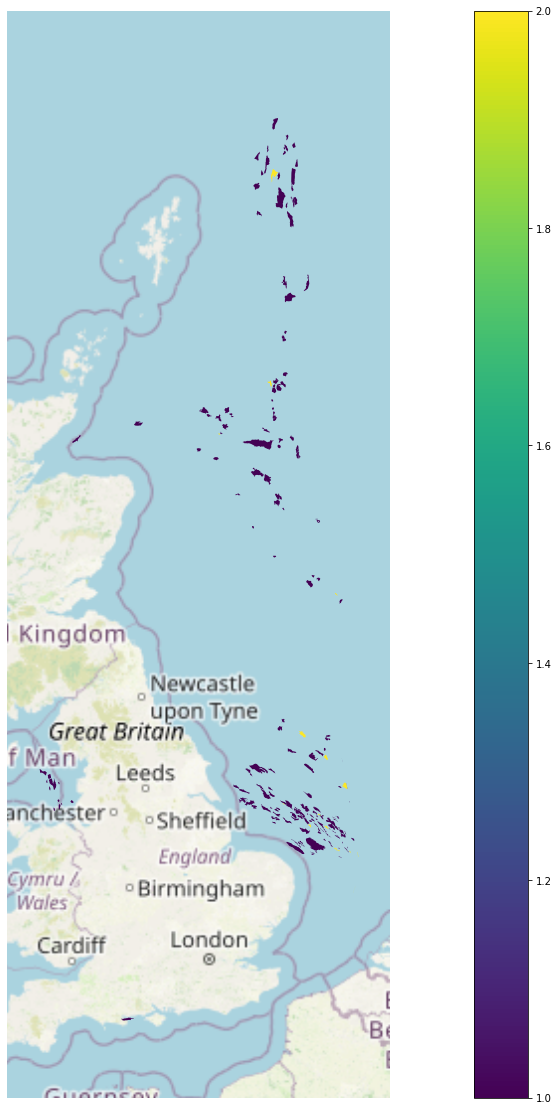

In [141]:
matching['color'] = matching.ASSESS_UNIT_TYPE.apply(lambda x: color_dict[x])
GB = gpd.clip(matching,mask=eu[eu.name == 'GB'])

background=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(background,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)

geoplot.choropleth(GB,hue='color',ax=ax,edgecolor='red', linewidth=0,legend=True)

In [13]:
#import pycountry
code = pycountry.countries.search_fuzzy('IT')[0].alpha_2
storage_unit[storage_unit['COUNTRYCODE']==code]

,OBJECTID,FORMATION_ID,STORAGE_UNIT_ID,STORAGE_UNIT_NAME,ASSESS_UNIT_TYPE,PERIOD_MIN,PERIOD_MAX,AGE_MIN,AGE_MAX,LITHOLOGY,...,COUNTRYCODE,LAMBERT_E,LAMBERT_N,X_DD,Y_DD,X,Y,Projection_Info,Date_Entered,geometry
75,174,IT_F_20121001124148805,IT_S_20121001151504215,Casirate 1 - Lombardia 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,pebblestone,...,IT,0.0,0.0,0.0,0.0,9.563056,45.489722,x: long - y: lat - WGS84,01-010-12 15:15:04,POINT (9.56306 45.48972)
76,175,IT_F_20121003174905644,IT_S_20121003175745519,Pandino 1 - Lombardia 2 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Piacenzian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,9.463889,45.413611,x: long - y: lat - WGS84,03-010-12 17:57:45,POINT (9.46389 45.41361)
77,176,IT_F_20121004153029368,IT_S_20121004153204821,Poggio Rusco 1 - Lombardia 3 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Aquitanian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,11.176389,44.947222,x: long - y: lat - WGS84,04-010-12 15:32:04,POINT (11.17639 44.94722)
78,177,IT_F_20121004163430395,IT_S_20121004175734558,S.Pietro in Casale 3 - Emilia 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,11.391944,44.716667,x: long - y: lat - WGS84,04-010-12 17:57:34,POINT (11.39194 44.71667)
79,178,IT_F_20121009153149008,IT_S_20121009153225384,Filetto1 - Emilia 2 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Gelasian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,12.071389,44.322500,x: long - y: lat - WGS84,09-010-12 15:32:25,POINT (12.07139 44.32250)
80,179,IT_F_20121009161532346,IT_S_20121009161621580,BAGNOLO MELLA SU,Saline Aquifer with hydrocarbon fields,NaN,NaN,NaN,NaN,NaN,...,IT,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,09-010-12 16:16:21,POINT (0.00000 0.00000)
81,180,IT_F_20121010122552181,IT_S_20121010122618306,Serena Nord 1 - Emilia mare SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,12.959167,44.110000,x: long - y: lat - WGS84,10-010-12 12:26:18,POINT (12.95917 44.11000)
82,181,IT_F_20121010135221305,IT_S_20121010135239899,Jesi 6 - Marche 1 SU,Saline Aquifer without hydrocarbon fields,NaN,NaN,NaN,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,13.260278,43.578611,x: long - y: lat - WGS84,10-010-12 13:52:39,POINT (13.26028 43.57861)
83,182,IT_F_20121010141900087,IT_S_20121010143318891,Notaresco 1 - Abruzzi 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Piacenzian,NaN,conglomerates,...,IT,0.0,0.0,0.0,0.0,13.956944,42.650833,x: long - y: lat - WGS84,10-010-12 14:33:18,POINT (13.95694 42.65083)
84,183,IT_F_20121010145802588,IT_S_20121010151127297,Pomarico 7 - Basilicata 1 SU,Saline Aquifer without hydrocarbon fields,quaternary,NaN,NaN,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,16.489444,40.518889,x: long - y: lat - WGS84,10-010-12 15:11:27,POINT (16.48944 40.51889)
